# Imports

In [218]:
from math import ceil
import json
import os
import sys

src_path = os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(src_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import visdom

from datasets import link_prediction
from layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator
import models
import utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up arguments for datasets, models and training.

In [271]:
args = {
    "task" : "link_prediction",
    
    "dataset" : "IAContactsHypertext",
    "dataset_path" : "/Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contacts_hypertext2009/ia-contacts_hypertext2009.edges",
    "mode" : "train",
    "generate_neg_examples" : False,
    
    "duplicate_examples" : True,
    "repeat_examples" : False,
    
    "self_loop" : True,
    "normalize_adj" : False,
    
    "cuda" : "True",
    "model" : "GraphSAGE",
    "agg_class" : "MeanAggregator",
    "hidden_dims" : [32],
    "dropout" : 0,
    "num_samples" : -1,
    
    "epochs" : 5,
    "batch_size" : 32,
    "lr" : 5e-4,
    "weight_decay" : 5e-4,
    "stats_per_batch" : 3,
    "visdom" : True,
    
    "load" : False,
    "save" : False
}
config = args
config['num_layers'] = len(config['hidden_dims']) + 1


if config['cuda'] and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
config['device'] = device

# Get the dataset, dataloader and model.

In [272]:
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'train',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contacts_hypertext2009/ia-contacts_hypertext2009.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: train
Number of vertices: 113
Number of static edges: 1010
Number of temporal edges: 6245
Number of examples/datapoints: 7044
--------------------------------


In [273]:
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=True, collate_fn=dataset.collate_wrapper)
input_dim, output_dim = dataset.get_dims()

In [274]:
agg_class = utils.get_agg_class(config['agg_class'])
model = models.GraphSAGE(input_dim, config['hidden_dims'],
                         output_dim, config['dropout'],
                         agg_class, config['num_samples'],
                         config['device'])
model.to(config['device'])
print(model)

GraphSAGE(
  (aggregators): ModuleList(
    (0): MeanAggregator()
    (1): MeanAggregator()
  )
  (fcs): ModuleList(
    (0): Linear(in_features=226, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0)
  (relu): ReLU()
)


# Compute ROC-AUC score for the untrained model.

In [275]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset before training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')

--------------------------------
Computing ROC-AUC score for the training dataset before training.
    Batch 1 / 221
    Batch 2 / 221
    Batch 3 / 221
    Batch 4 / 221
    Batch 5 / 221
    Batch 6 / 221
    Batch 7 / 221
    Batch 8 / 221
    Batch 9 / 221
    Batch 10 / 221
    Batch 11 / 221
    Batch 12 / 221
    Batch 13 / 221
    Batch 14 / 221
    Batch 15 / 221
    Batch 16 / 221
    Batch 17 / 221
    Batch 18 / 221
    Batch 19 / 221
    Batch 20 / 221
    Batch 21 / 221
    Batch 22 / 221
    Batch 23 / 221
    Batch 24 / 221
    Batch 25 / 221
    Batch 26 / 221
    Batch 27 / 221
    Batch 28 / 221
    Batch 29 / 221
    Batch 30 / 221
    Batch 31 / 221
    Batch 32 / 221
    Batch 33 / 221
    Batch 34 / 221
    Batch 35 / 221
    Batch 36 / 221
    Batch 37 / 221
    Batch 38 / 221
    Batch 39 / 221
    Batch 40 / 221
    Batch 41 / 221
    Batch 42 / 221
    Batch 43 / 221
    Batch 44 / 221
    Batch 45 / 221
    Batch 46 / 221
    Batch 47 / 221
    Batch 48 / 22

# Train.

In [276]:
if not config['load']:
    use_visdom = config['visdom']
    if use_visdom:
        vis = visdom.Visdom()
        loss_window = None
    criterion = utils.get_criterion(config['task'])
    optimizer = optim.Adam(model.parameters(), lr=config['lr'],
                           weight_decay=config['weight_decay'])
    epochs = config['epochs']
    stats_per_batch = config['stats_per_batch']
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.8)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 400], gamma=0.7)
    model.train()
    print('--------------------------------')
    print('Training.')
    for epoch in range(epochs):
        print('Epoch {} / {}'.format(epoch+1, epochs))
        running_loss = 0.0
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            loss = criterion(scores, labels.float())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
            if (idx + 1) % stats_per_batch == 0:
                running_loss /= stats_per_batch
                print('    Batch {} / {}: loss {:.4f}'.format(
                    idx+1, num_batches, running_loss))
                if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
                    area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
                    print('    ROC-AUC score: {:.4f}'.format(area))
                running_loss = 0.0
                num_correct, num_examples = 0, 0
            if use_visdom:
                if loss_window is None:
                    loss_window = vis.line(
                        Y=[loss.item()],
                        X=[epoch*num_batches+idx],
                        opts=dict(xlabel='batch', ylabel='Loss', title='Training Loss', legend=['Loss']))
                else:
                    vis.line(
                        [loss.item()],
                        [epoch*num_batches+idx],
                        win=loss_window,
                        update='append')
            scheduler.step()
    if use_visdom:
        vis.close(win=loss_window)
    print('Finished training.')
    print('--------------------------------')

--------------------------------
Training.
Epoch 1 / 5
    Batch 3 / 221: loss 0.6928
    ROC-AUC score: 0.5961
    Batch 6 / 221: loss 0.6931
    ROC-AUC score: 0.4762
    Batch 9 / 221: loss 0.6919
    ROC-AUC score: 0.5977
    Batch 12 / 221: loss 0.6918
    ROC-AUC score: 0.7098
    Batch 15 / 221: loss 0.6903
    ROC-AUC score: 0.7935
    Batch 18 / 221: loss 0.6909
    ROC-AUC score: 0.7148
    Batch 21 / 221: loss 0.6908
    ROC-AUC score: 0.6431
    Batch 24 / 221: loss 0.6885
    ROC-AUC score: 0.5917
    Batch 27 / 221: loss 0.6908
    ROC-AUC score: 0.6508
    Batch 30 / 221: loss 0.6857
    ROC-AUC score: 0.6500
    Batch 33 / 221: loss 0.6875
    ROC-AUC score: 0.6667
    Batch 36 / 221: loss 0.6893
    ROC-AUC score: 0.6640
    Batch 39 / 221: loss 0.6895
    ROC-AUC score: 0.7063
    Batch 42 / 221: loss 0.6887
    ROC-AUC score: 0.6118
    Batch 45 / 221: loss 0.6830
    ROC-AUC score: 0.7773
    Batch 48 / 221: loss 0.6850
    ROC-AUC score: 0.7667
    Batch 51 / 221: 

    Batch 201 / 221: loss 0.5829
    ROC-AUC score: 0.8431
    Batch 204 / 221: loss 0.6051
    ROC-AUC score: 0.8294
    Batch 207 / 221: loss 0.6462
    ROC-AUC score: 0.7864
    Batch 210 / 221: loss 0.5396
    ROC-AUC score: 0.8118
    Batch 213 / 221: loss 0.5205
    ROC-AUC score: 0.8073
    Batch 216 / 221: loss 0.5981
    ROC-AUC score: 0.7222
    Batch 219 / 221: loss 0.5962
    ROC-AUC score: 0.7287
Epoch 3 / 5
    Batch 3 / 221: loss 0.5700
    ROC-AUC score: 0.8651
    Batch 6 / 221: loss 0.5222
    ROC-AUC score: 0.8413
    Batch 9 / 221: loss 0.5420
    ROC-AUC score: 0.7882
    Batch 12 / 221: loss 0.6390
    ROC-AUC score: 0.7591
    Batch 15 / 221: loss 0.6330
    ROC-AUC score: 0.9221
    Batch 18 / 221: loss 0.5414
    ROC-AUC score: 0.8333
    Batch 21 / 221: loss 0.5660
    ROC-AUC score: 0.8968
    Batch 24 / 221: loss 0.5625
    ROC-AUC score: 0.6275
    Batch 27 / 221: loss 0.5643
    ROC-AUC score: 0.7583
    Batch 30 / 221: loss 0.5606
    ROC-AUC score: 0.916

    Batch 186 / 221: loss 0.5623
    ROC-AUC score: 0.9318
    Batch 189 / 221: loss 0.5304
    ROC-AUC score: 0.8300
    Batch 192 / 221: loss 0.5390
    ROC-AUC score: 0.8571
    Batch 195 / 221: loss 0.5930
    ROC-AUC score: 0.5938
    Batch 198 / 221: loss 0.6114
    ROC-AUC score: 0.8300
    Batch 201 / 221: loss 0.5581
    ROC-AUC score: 0.8708
    Batch 204 / 221: loss 0.5550
    ROC-AUC score: 0.8706
    Batch 207 / 221: loss 0.5523
    ROC-AUC score: 0.8727
    Batch 210 / 221: loss 0.5190
    ROC-AUC score: 0.8442
    Batch 213 / 221: loss 0.5941
    ROC-AUC score: 0.9583
    Batch 216 / 221: loss 0.5426
    ROC-AUC score: 0.8392
    Batch 219 / 221: loss 0.6195
    ROC-AUC score: 0.7302
Epoch 5 / 5
    Batch 3 / 221: loss 0.4902
    ROC-AUC score: 0.8532
    Batch 6 / 221: loss 0.5997
    ROC-AUC score: 0.6627
    Batch 9 / 221: loss 0.5849
    ROC-AUC score: 0.8196
    Batch 12 / 221: loss 0.5402
    ROC-AUC score: 0.8135
    Batch 15 / 221: loss 0.5620
    ROC-AUC score: 

In [277]:
if not config['load']:
    if config['save']:
        print('--------------------------------')
        directory = os.path.join(os.path.dirname(os.getcwd()),
                                'trained_models')
        if not os.path.exists(directory):
            os.makedirs(directory)
        fname = utils.get_fname(config)
        path = os.path.join(directory, fname)
        print('Saving model at {}'.format(path))
        torch.save(model.state_dict(), path)
        print('Finished saving model.')
        print('--------------------------------')

# Compute ROC-AUC score after training.

In [278]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset after training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')


--------------------------------
Computing ROC-AUC score for the training dataset after training.
    Batch 1 / 221
    Batch 2 / 221
    Batch 3 / 221
    Batch 4 / 221
    Batch 5 / 221
    Batch 6 / 221
    Batch 7 / 221
    Batch 8 / 221
    Batch 9 / 221
    Batch 10 / 221
    Batch 11 / 221
    Batch 12 / 221
    Batch 13 / 221
    Batch 14 / 221
    Batch 15 / 221
    Batch 16 / 221
    Batch 17 / 221
    Batch 18 / 221
    Batch 19 / 221
    Batch 20 / 221
    Batch 21 / 221
    Batch 22 / 221
    Batch 23 / 221
    Batch 24 / 221
    Batch 25 / 221
    Batch 26 / 221
    Batch 27 / 221
    Batch 28 / 221
    Batch 29 / 221
    Batch 30 / 221
    Batch 31 / 221
    Batch 32 / 221
    Batch 33 / 221
    Batch 34 / 221
    Batch 35 / 221
    Batch 36 / 221
    Batch 37 / 221
    Batch 38 / 221
    Batch 39 / 221
    Batch 40 / 221
    Batch 41 / 221
    Batch 42 / 221
    Batch 43 / 221
    Batch 44 / 221
    Batch 45 / 221
    Batch 46 / 221
    Batch 47 / 221
    Batch 48 / 221

# Plot the true positive rate and true negative rate vs threshold.

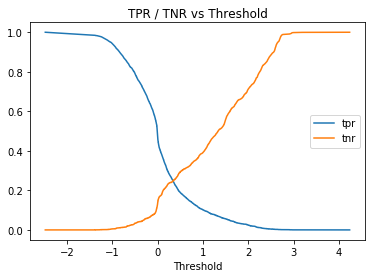

In [279]:
if not config['load']:
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    plt.plot(thresholds, tpr, label='tpr')
    plt.plot(thresholds, tnr, label='tnr')
    plt.xlabel('Threshold')
    plt.title('TPR / TNR vs Threshold')
    plt.legend()

# Choose an appropriate threshold and generate classification report on the train set.

In [280]:
idx1 = np.where(tpr <= tnr)[0]
idx2 = np.where(tpr >= tnr)[0]
t = thresholds[idx1[-1]]
total_correct, total_examples = 0, 0
y_true, y_pred = [], []
num_batches = int(ceil(len(dataset) / config['batch_size']))
with torch.no_grad():
    for (idx, batch) in enumerate(loader):
        edges, features, node_layers, mappings, rows, labels = batch
        features, labels = features.to(device), labels.to(device)
        out = model(features, node_layers, mappings, rows)
        all_pairs = torch.mm(out, out.t())
        scores = all_pairs[edges.T]
        predictions = (scores >= t).long()
        y_true.extend(labels.detach().numpy())
        y_pred.extend(predictions.detach().numpy())
        total_correct += torch.sum(predictions == labels.long()).item()
        total_examples += len(labels) 
        print('    Batch {} / {}'.format(idx+1, num_batches))
print('Threshold: {:.4f}, accuracy: {:.4f}'.format(t, total_correct / total_examples))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
print('Classification report\n', report)

    Batch 1 / 221
    Batch 2 / 221
    Batch 3 / 221
    Batch 4 / 221
    Batch 5 / 221
    Batch 6 / 221
    Batch 7 / 221
    Batch 8 / 221
    Batch 9 / 221
    Batch 10 / 221
    Batch 11 / 221
    Batch 12 / 221
    Batch 13 / 221
    Batch 14 / 221
    Batch 15 / 221
    Batch 16 / 221
    Batch 17 / 221
    Batch 18 / 221
    Batch 19 / 221
    Batch 20 / 221
    Batch 21 / 221
    Batch 22 / 221
    Batch 23 / 221
    Batch 24 / 221
    Batch 25 / 221
    Batch 26 / 221
    Batch 27 / 221
    Batch 28 / 221
    Batch 29 / 221
    Batch 30 / 221
    Batch 31 / 221
    Batch 32 / 221
    Batch 33 / 221
    Batch 34 / 221
    Batch 35 / 221
    Batch 36 / 221
    Batch 37 / 221
    Batch 38 / 221
    Batch 39 / 221
    Batch 40 / 221
    Batch 41 / 221
    Batch 42 / 221
    Batch 43 / 221
    Batch 44 / 221
    Batch 45 / 221
    Batch 46 / 221
    Batch 47 / 221
    Batch 48 / 221
    Batch 49 / 221
    Batch 50 / 221
    Batch 51 / 221
    Batch 52 / 221
    Batch 53 / 221
  

# Evaluate on validation set.

In [281]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'val',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Computing ROC-AUC score for the validation dataset after training.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores, y_pred = [], [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    y_pred.extend(predictions.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        print('    Batch {} / {}: loss {:.4f}, accuracy {:.4f}'.format(
            idx+1, num_batches, running_loss, accuracy))
        if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
            area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
            print('    ROC-AUC score: {:.4f}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {:.4f}'.format(area))
print('Classification report\n', report)
print('Finished validating.')
print('--------------------------------')

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contacts_hypertext2009/ia-contacts_hypertext2009.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: val
Number of vertices: 113
Number of static edges: 1636
Number of temporal edges: 10409
Number of examples/datapoints: 8550
--------------------------------
--------------------------------
Computing ROC-AUC score for the validation dataset after training.
    Batch 3 / 268: loss 0.6548, accuracy 0.6354
    ROC-AUC score: 0.7063
    Batch 6 / 268: loss 0.6217, accuracy 0.6771
    ROC-AUC score: 0.7247
    Batch 9 / 268: loss 0.5647, accuracy 0.7500
    ROC-AUC score: 0.8016
    Batch 12 / 268: loss 0.6604, accuracy 0.7604
    ROC-AUC score: 0.7773
    Batch 15 / 268: loss 0.5859, accuracy 0.7500
    ROC-AUC score: 0.7500
    Batch 18 / 268: loss 0.6416, accuracy 0

# Evaluate on test set.

In [282]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'test',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Computing ROC-AUC score for the test dataset after training.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores, y_pred = [], [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    y_pred.extend(predictions.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        print('    Batch {} / {}: loss {:.4f}, accuracy {:.4f}'.format(
            idx+1, num_batches, running_loss, accuracy))
        if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
            area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
            print('    ROC-AUC score: {:.4f}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {:.4f}'.format(area))
print('Classification report\n', report)
print('Finished testing.')
print('--------------------------------')

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contacts_hypertext2009/ia-contacts_hypertext2009.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: test
Number of vertices: 113
Number of static edges: 2096
Number of temporal edges: 15613
Number of examples/datapoints: 8278
--------------------------------
--------------------------------
Computing ROC-AUC score for the test dataset after training.
    Batch 3 / 259: loss 0.5884, accuracy 0.7500
    ROC-AUC score: 0.7500
    Batch 6 / 259: loss 0.6292, accuracy 0.7500
    ROC-AUC score: 0.6314
    Batch 9 / 259: loss 0.7483, accuracy 0.6458
    ROC-AUC score: 0.4000
    Batch 12 / 259: loss 0.6740, accuracy 0.6562
    ROC-AUC score: 0.7804
    Batch 15 / 259: loss 0.6475, accuracy 0.7396
    ROC-AUC score: 0.8039
    Batch 18 / 259: loss 0.6728, accuracy 0.6562